# California housing regression

In this notebook we'll use the ``ITEA_regressor`` to search for a good expression, that will be encapsulated inside the  ``ITExpr_regressor`` class, and it will be used for the regression task of predicting California housing prices.

In [1]:
import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets

from sklearn.model_selection import train_test_split
from IPython.display         import display

from itea.regression import ITEA_regressor
from itea.inspection import *

import warnings
warnings.filterwarnings(action='ignore', module=r'itea')

The California Housing data set contains 8 features.

In this notebook, we'll provide the transformation functions and their derivatives, instead of using the itea feature of extracting the derivatives using Jax.

## Creating and fitting an ``ITEA_regressor``

In [2]:
housing_data = datasets.fetch_california_housing() 
X, y         = housing_data['data'], housing_data['target']
labels       = housing_data['feature_names']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

tfuncs = {
    'log'      : np.log,
    'sqrt.abs' : lambda x: np.sqrt(np.abs(x)), 
    'id'       : lambda x: x,
    'sin'      : np.sin,
    'cos'      : np.cos,
    'exp'      : np.exp
}

tfuncs_dx = {
    'log'      : lambda x: 1/x,
    'sqrt.abs' : lambda x: x/( 2*(np.abs(x)**(3/2)) ),
    'id'       : lambda x: np.ones_like(x),
    'sin'      : np.cos,
    'cos'      : lambda x: -np.sin(x),
    'exp'      : np.exp,
}

reg = ITEA_regressor(
    gens         = 50,
    popsize      = 50,
    max_terms    = 5,
    expolim      = (0, 2),
    verbose      = 10,
    tfuncs       = tfuncs,
    tfuncs_dx    = tfuncs_dx,
    labels       = labels,
    random_state = 42,
    simplify_method = 'simplify_by_coef'
).fit(X_train, y_train)

gen | smallest fitness | mean fitness | highest fitness | remaining time
----------------------------------------------------------------------------
  0 |         0.879653 |     1.075671 |        1.153701 | 1min0sec    
 10 |         0.794826 |     0.828574 |        0.983679 | 1min58sec   
 20 |         0.788833 |     0.799124 |        0.850923 | 1min33sec   
 30 |         0.740517 |     0.783561 |        0.806966 | 0min58sec   
 40 |         0.756137 |     0.777656 |        0.806420 | 0min28sec   


## Inspecting the results from ``ITEA_regressor`` and ``ITExpr_regressor``

We can see the convergence of the fitness, the number of terms, or tree complexity by using the ``ITEA_summarizer``, an inspector class focused on the ``ITEA``:

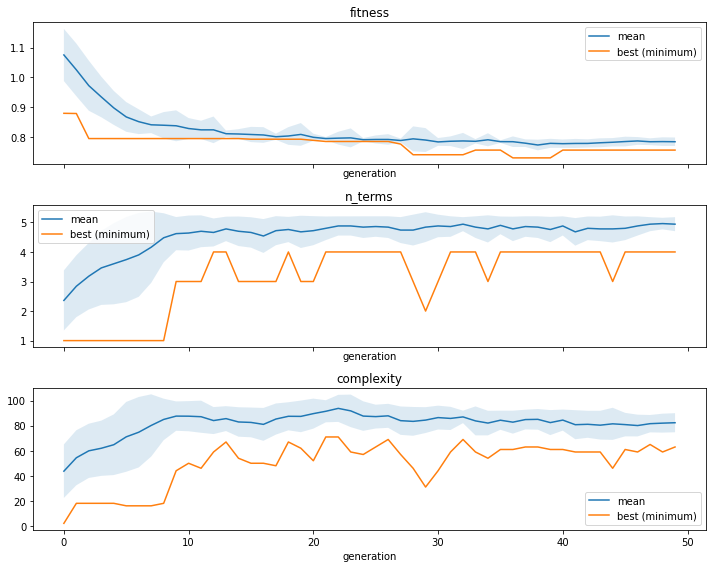

In [3]:
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

summarizer = ITEA_summarizer(itea=reg).fit(X_train, y_train)

summarizer.plot_convergence(
    data=['fitness', 'n_terms', 'complexity'],
    ax=axs,
    show=False
)

plt.tight_layout()
plt.show()

Now that we have fitted the ITEA, our ``reg`` contains the ``bestsol_`` attribute, which is a fitted instance of ``ITExpr_regressor`` ready to be used. Let us see the final expression and the execution time.

In [4]:
final_itexpr = reg.bestsol_

print('\nFinal expression:\n', final_itexpr.to_str(term_separator=' +\n'))
print(f'\nElapsed time: {reg.exectime_}')
print(f'\nSelected Features: {final_itexpr.selected_features_}')


Final expression:
 9.361*log(MedInc^2 * HouseAge * AveRooms * AveBedrms * Population^2 * Latitude * Longitude^2) +
-9.662*log(HouseAge * Population^2 * AveOccup * Longitude^2) +
-8.436*log(MedInc^2 * HouseAge^2 * AveRooms^2 * AveBedrms * Population^2 * Latitude^2) +
-1.954*log(AveRooms) +
8.739*log(HouseAge^2 * AveRooms * Population^2 * AveOccup * Longitude^2) +
-53.078

Elapsed time: 147.87880086898804

Selected Features: ['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude']


In [5]:
# just remembering that ITEA and ITExpr implements scikits
# base classes. We can check all parameters with:
print(final_itexpr.get_params)

<bound method BaseEstimator.get_params of ITExpr_regressor(expr=[('log', [2, 1, 1, 1, 2, 0, 1, 2]),
                       ('log', [0, 1, 0, 0, 2, 1, 0, 2]),
                       ('log', [2, 2, 2, 1, 2, 0, 2, 0]),
                       ('log', [0, 0, 1, 0, 0, 0, 0, 0]),
                       ('log', [0, 2, 1, 0, 2, 1, 0, 2])],
                 labels=array(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude'], dtype='<U10'),
                 tfuncs={'cos': <ufunc 'cos'>, 'exp': <ufunc 'exp'>,
                         'id': <function <lambda> at 0x7fc5987794d0>,
                         'log': <ufunc 'log'>, 'sin': <ufunc 'sin'>,
                         'sqrt.abs': <function <lambda> at 0x7fc598779b00>})>


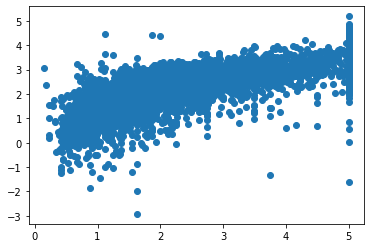

In [6]:
fig, axs = plt.subplots()

axs.scatter(y_test, final_itexpr.predict(X_test))
plt.show()

We can use the ``ITExpr_inspector`` to see information for each term.

In [7]:
display(pd.DataFrame(
    ITExpr_inspector(
        itexpr=final_itexpr, tfuncs=tfuncs
    ).fit(X_train, y_train).terms_analysis()
))

,coef,func,strengths,coef\nstderr.,mean pairwise\ndisentanglement,mean mutual\ninformation,prediction\nvar.
0,9.361,log,"[2, 1, 1, 1, 2, 0, 1, 2]",0.22,0.535,0.603,268.140
1,-9.662,log,"[0, 1, 0, 0, 2, 1, 0, 2]",0.221,0.494,0.527,221.432
2,-8.436,log,"[2, 2, 2, 1, 2, 0, 2, 0]",0.222,0.544,0.609,263.430
3,-1.954,log,"[0, 0, 1, 0, 0, 0, 0, 0]",0.038,0.075,0.187,0.290
4,8.739,log,"[0, 2, 1, 0, 2, 1, 0, 2]",0.222,0.520,0.553,214.239
5,-53.078,intercept,---,1.325,0.000,0.000,0.000


## Explaining the ``IT_regressor`` expression using Partial Effects

We can obtain feature importances using the Partial Effects and the ``ITExpr_explainer``.

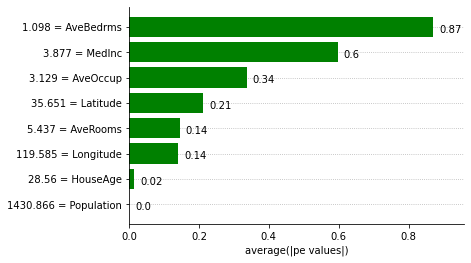

In [8]:
explainer = ITExpr_explainer(
    itexpr=final_itexpr, tfuncs=tfuncs, tfuncs_dx=tfuncs_dx).fit(X, y)

explainer.plot_feature_importances(
    X=X_train,
    importance_method='pe',
    grouping_threshold=0.0,
    barh_kw={'color':'green'}
)

The Partial Effects at the Means can help understand how the contribution of each variable changes according to its values when their covariables are fixed at the means.

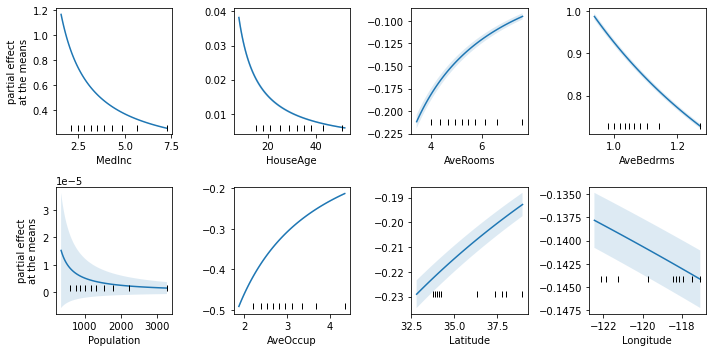

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5))

explainer.plot_partial_effects_at_means(
    X=X_test,
    features=range(8),
    ax=axs,
    num_points=100,
    share_y=False,
    show_err=True,
    show=False
)

plt.tight_layout()
plt.show()

Finally, we can also plot the mean relative importances of each feature by calculating the average Partial Effect for each interval when the output is discretized.

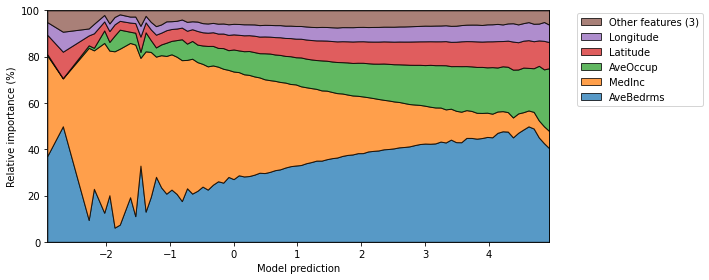

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

explainer.plot_normalized_partial_effects(
    grouping_threshold=0.1, show=False,
    num_points=100, ax=ax
)

plt.tight_layout()